In [1]:
import pandas as pd
import numpy as np

import boxball_loader as bbl
import baseball_stats_utils as bsu

In [2]:
# Load the batting stats
yrs = bbl.Eras.since(2000)
batting = bbl.load_batting(yrs, coalesce_type=bbl.CoalesceMode.PLAYER_SEASON)
batting = bsu.add_batting_rate_stats(batting).query('pa>0')
batting['pa'] = batting['pa'].astype(int)
batting.shape


(19701, 27)

In [3]:
# Merge in birth year and compute a simple age
birth_years = bbl.load_people().set_index('player_id')['birth_year'].dropna().astype(int)
batting = pd.merge(left=batting.reset_index(), right=birth_years, on='player_id')
batting['age'] = batting['yr'] - batting['birth_year']

batting.shape


(19701, 31)

In [4]:
#interesting_cols = ['player_id', 'yr', 'woba', 'pa', 'age']
# Export the pre-processed data to share with others
batting[['player_id', 'yr', 'age', 'pa', 'woba']].to_csv('~/Dropbox/Public/batting.csv', index=False)

In [5]:
# Merge the batting table with itself, on yr==prev_yr, to get rows with both years together
batting['prev_yr'] = batting['yr']-1


In [6]:
combined = pd.merge(left=batting[['player_id', 'yr', 'woba', 'pa', 'age', 'prev_yr']], right=batting[['player_id', 'yr', 'woba', 'pa']], left_on=['player_id', 'prev_yr'], right_on=['player_id', 'yr'], suffixes=['', '_prev'])
combined

,player_id,yr,woba,pa,age,prev_yr,yr_prev,woba_prev,pa_prev
0,abbotje01,2001,0.291304,46,29,2000,2000,0.319000,239
1,abbotku01,2001,0.191556,9,32,2000,2000,0.283181,173
2,abbotpa01,2001,0.215500,4,34,2000,2000,0.418800,5
3,abercre01,2007,0.238350,80,27,2006,2006,0.259476,277
4,abercre01,2008,0.353051,59,28,2007,2007,0.238350,80
...,...,...,...,...,...,...,...,...,...
13721,zuninmi01,2016,0.334229,192,25,2015,2015,0.230460,378
13722,zuninmi01,2017,0.353122,435,26,2016,2016,0.334229,192
13723,zuninmi01,2018,0.282889,405,27,2017,2017,0.353122,435
13724,zuninmi01,2019,0.237038,289,28,2018,2018,0.282889,405


In [7]:
combined['woba_delta'] = combined['woba']-combined['woba_prev']
#combined['weight'] = combined[['pa', 'pa_prev']].min(axis=1)
combined['weight'] = combined['pa']
combined['delta_weighted'] = combined['woba_delta'] * combined['weight']
combined

,player_id,yr,woba,pa,age,prev_yr,yr_prev,woba_prev,pa_prev,woba_delta,weight,delta_weighted
0,abbotje01,2001,0.291304,46,29,2000,2000,0.319000,239,-0.027696,46,-1.274000
1,abbotku01,2001,0.191556,9,32,2000,2000,0.283181,173,-0.091626,9,-0.824632
2,abbotpa01,2001,0.215500,4,34,2000,2000,0.418800,5,-0.203300,4,-0.813200
3,abercre01,2007,0.238350,80,27,2006,2006,0.259476,277,-0.021126,80,-1.690109
4,abercre01,2008,0.353051,59,28,2007,2007,0.238350,80,0.114701,59,6.767350
...,...,...,...,...,...,...,...,...,...,...,...,...
13721,zuninmi01,2016,0.334229,192,25,2015,2015,0.230460,378,0.103769,192,19.923619
13722,zuninmi01,2017,0.353122,435,26,2016,2016,0.334229,192,0.018893,435,8.218313
13723,zuninmi01,2018,0.282889,405,27,2017,2017,0.353122,435,-0.070233,405,-28.444345
13724,zuninmi01,2019,0.237038,289,28,2018,2018,0.282889,405,-0.045851,289,-13.250889


In [8]:
bucketed = combined.groupby(['age'])[['weight', 'delta_weighted']].sum()
bucketed['delta_avg'] = bucketed['delta_weighted']/bucketed['weight']
bucketed

,weight,delta_weighted,delta_avg
age,,,
20,318,7.266706,0.022851
21,7276,137.127343,0.018847
22,30565,-57.142324,-0.001870
23,80238,1399.915242,0.017447
24,148842,1001.061792,0.006726
25,239817,1858.061326,0.007748
26,294916,1413.739899,0.004794
27,332452,1090.558832,0.003280
28,323134,-585.853367,-0.001813


In [9]:
# What might a career look like, if we apply each age's adjustment in series
bucketed['delta_avg'].cumsum()+.270

age
20    0.292851
21    0.311698
22    0.309828
23    0.327275
24    0.334001
25    0.341749
26    0.346543
27    0.349823
28    0.348010
29    0.347710
30    0.348153
31    0.343929
32    0.336369
33    0.332208
34    0.327808
35    0.321688
36    0.311184
37    0.299691
38    0.287527
39    0.275217
40    0.262262
41    0.242427
42    0.223004
43    0.237953
44    0.210181
45    0.212111
46    0.210085
47    0.207984
48    0.166837
49    0.138893
Name: delta_avg, dtype: float64

<AxesSubplot:xlabel='age'>

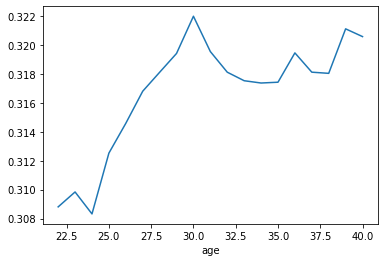

In [10]:
buckets_raw = batting.groupby('age')[['g', 'ab', 'r', 'h', '_2b', '_3b', 'hr', 'rbi', 'sb',
       'cs', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf', 'gidp']].sum()
buckets_raw = bsu.add_batting_rate_stats(buckets_raw)
buckets_raw.loc[22:40, 'woba'].plot()


In [11]:
combined['woba_weighted'] = combined['woba'] * combined['weight']
combined['woba_prev_weighted'] = combined['woba_prev'] * combined['weight']
combined.sample()

,player_id,yr,woba,pa,age,prev_yr,yr_prev,woba_prev,pa_prev,woba_delta,weight,delta_weighted,woba_weighted,woba_prev_weighted
9881,pineijo01,2011,0.0,5,33,2010,2010,0.2808,5,-0.2808,5,-1.404,0.0,1.404


In [12]:
age27 = combined.query('age==27')[['pa', 'pa_prev', 'woba_weighted', 'woba_prev_weighted', 'weight']].sum()
age27['woba'] = age27['woba_weighted']/age27['weight']
age27['woba_prev'] = age27['woba_prev_weighted']/age27['weight']
age27

pa                    332452.000000
pa_prev               314861.000000
woba_weighted         105716.474359
woba_prev_weighted    104625.915527
weight                332452.000000
woba                       0.317990
woba_prev                  0.314710
dtype: float64

In [13]:
age27 = combined.query('age==26')[['pa', 'pa_prev', 'woba_weighted', 'woba_prev_weighted', 'weight']].sum()
age27['woba'] = age27['woba_weighted']/age27['weight']
age27['woba_prev'] = age27['woba_prev_weighted']/age27['weight']
age27

pa                    294916.000000
pa_prev               274939.000000
woba_weighted          93301.833299
woba_prev_weighted     91888.093400
weight                294916.000000
woba                       0.316367
woba_prev                  0.311574
dtype: float64